# Preserving NaN missing values with safeguards

In this example, we compare how three lossy compressors (ZFP, SZ3 [v3.2 and v3.3], and SPERR) handle missing values that are encoded as NaNs. We compress a single day (four 6h observations) of sea-only satellite observation data, where data is missing on land (static) and wherever is not currently covered by the satellites (dynamic). Finally, we apply safeguards to guarantee that NaN values are preserved.

Since the SPERR codec does not support NaN values, we replace them with zeros before encoding with SPERR.

In [1]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
from pathlib import Path

import earthkit.plots
import humanize
import numcodecs.compat
import numpy as np
import xarray as xr
from numcodecs.abc import Codec
from numcodecs_combinators.stack import CodecStack
from numcodecs_safeguards import SafeguardsCodec
from numcodecs_wasm_sperr import Sperr
from numcodecs_wasm_sz3 import Sz3 as Sz3_3
from numcodecs_wasm_zfp import Zfp
from numcodecs_zero import ZeroCodec

In [3]:
# we want to test both SZ3 v3.2 and SZ3 v3.3
# but pip doesn't allow installing two different versions of the same package
# so we instead import the SZ3 v3.2 package directly from its PyPi wheel

import shutil
import sys
import tempfile
from urllib.request import urlopen
from zipfile import ZipFile

numcodecs_wasm_sz3_2_url = (
    "https://files.pythonhosted.org/packages/a0/c4/"
    + "8e0cdbda2ffd5a591bf31c15e274984e065dfbfff27a725acf481c2a2bde/"
    + "numcodecs_wasm_sz3-0.7.0-py3-none-any.whl"
)

with tempfile.TemporaryDirectory() as tmp:
    numcodecs_wasm_sz3_2_wheel = Path(tmp) / Path(numcodecs_wasm_sz3_2_url).name

    with urlopen(numcodecs_wasm_sz3_2_url) as response:
        with numcodecs_wasm_sz3_2_wheel.open("wb") as wheel:
            shutil.copyfileobj(response, wheel)

        with ZipFile(numcodecs_wasm_sz3_2_wheel, "r") as wheel:
            numcodecs_wasm_sz3_2_source = wheel.extractall(tmp)
            (Path(tmp) / "numcodecs_wasm_sz3").rename(
                Path(tmp) / "numcodecs_wasm_sz3_2"
            )
            sys.path.append(tmp)
            from numcodecs_wasm_sz3_2 import Sz3 as Sz3_2

            sys.path.remove(tmp)

In [4]:
wvpa = xr.open_dataset(
    Path() / "data" / "hoaps-c.r30.h06.wvpa.2020-08" / "data.nc",
    engine="netcdf4",
    decode_timedelta=True,
).wvpa.sel(time="2020-08-02")
wvpa.sizes

Frozen({'time': 4, 'lat': 320, 'lon': 720})

In [5]:
from compression_safeguards.utils.cast import as_bits


def compute_corrections_percentage(my_wvpa: np.ndarray, orig_wvpa: np.ndarray) -> float:
    return np.mean(
        ~((my_wvpa == orig_wvpa) | (np.isnan(my_wvpa) & np.isnan(orig_wvpa)))
    )


def compute_corrections_percentage_nan(
    my_wvpa: np.ndarray, orig_wvpa: np.ndarray
) -> float:
    return np.mean(as_bits(my_wvpa.values) != as_bits(orig_wvpa.values))

## Compressing water vapour path with lossy compressors and safeguards

We configure each compressor and the safeguards with an absolute error bound of 0.1 kg/m^2. For the safeguards, we compare (a) considering NaN values only as equal if their bit patterns match and (b) considering all NaN values as equal.

In [6]:
eb_abs = 0.1

In [7]:
zfp = Zfp(mode="fixed-accuracy", tolerance=eb_abs, non_finite="allow-unsafe")

wvpa_zfp_enc = zfp.encode(wvpa.values)
wvpa_zfp = wvpa.copy(deep=True, data=zfp.decode(wvpa_zfp_enc))
wvpa_zfp_cr = wvpa.nbytes / wvpa_zfp_enc.nbytes

In [8]:
zfp_sg = SafeguardsCodec(
    codec=zfp, safeguards=[dict(kind="eb", type="abs", eb=eb_abs, equal_nan=True)]
)

wvpa_zfp_sg_enc = zfp_sg.encode(wvpa.values)
wvpa_zfp_sg = wvpa.copy(deep=True, data=zfp_sg.decode(wvpa_zfp_sg_enc))
wvpa_zfp_sg_cr = wvpa.nbytes / np.asarray(wvpa_zfp_sg_enc).nbytes

In [9]:
zfp_sg_nan = SafeguardsCodec(
    codec=zfp, safeguards=[dict(kind="eb", type="abs", eb=eb_abs, equal_nan=False)]
)

wvpa_zfp_sg_nan_enc = zfp_sg_nan.encode(wvpa.values)
wvpa_zfp_sg_nan = wvpa.copy(deep=True, data=zfp_sg_nan.decode(wvpa_zfp_sg_nan_enc))
wvpa_zfp_sg_nan_cr = wvpa.nbytes / np.asarray(wvpa_zfp_sg_nan_enc).nbytes

In [10]:
sz3_2 = Sz3_2(eb_mode="abs", eb_abs=eb_abs)

wvpa_sz3_2_enc = sz3_2.encode(wvpa.values)
wvpa_sz3_2 = wvpa.copy(deep=True, data=sz3_2.decode(wvpa_sz3_2_enc))
wvpa_sz3_2_cr = wvpa.nbytes / np.asarray(wvpa_sz3_2_enc).nbytes

In [11]:
sz3_2_sg = SafeguardsCodec(
    codec=sz3_2, safeguards=[dict(kind="eb", type="abs", eb=eb_abs, equal_nan=True)]
)

wvpa_sz3_2_sg_enc = sz3_2_sg.encode(wvpa.values)
wvpa_sz3_2_sg = wvpa.copy(deep=True, data=sz3_2_sg.decode(wvpa_sz3_2_sg_enc))
wvpa_sz3_2_sg_cr = wvpa.nbytes / np.asarray(wvpa_sz3_2_sg_enc).nbytes

In [12]:
sz3_2_sg_nan = SafeguardsCodec(
    codec=sz3_2, safeguards=[dict(kind="eb", type="abs", eb=eb_abs, equal_nan=False)]
)

wvpa_sz3_2_sg_nan_enc = sz3_2_sg_nan.encode(wvpa.values)
wvpa_sz3_2_sg_nan = wvpa.copy(
    deep=True, data=sz3_2_sg_nan.decode(wvpa_sz3_2_sg_nan_enc)
)
wvpa_sz3_2_sg_nan_cr = wvpa.nbytes / np.asarray(wvpa_sz3_2_sg_nan_enc).nbytes

In [13]:
sz3_3 = Sz3_3(eb_mode="abs", eb_abs=eb_abs)

wvpa_sz3_3_enc = sz3_3.encode(wvpa.values)
wvpa_sz3_3 = wvpa.copy(deep=True, data=sz3_3.decode(wvpa_sz3_3_enc))
wvpa_sz3_3_cr = wvpa.nbytes / np.asarray(wvpa_sz3_3_enc).nbytes

In [14]:
sz3_3_sg = SafeguardsCodec(
    codec=sz3_3, safeguards=[dict(kind="eb", type="abs", eb=eb_abs, equal_nan=True)]
)

wvpa_sz3_3_sg_enc = sz3_3_sg.encode(wvpa.values)
wvpa_sz3_3_sg = wvpa.copy(deep=True, data=sz3_3_sg.decode(wvpa_sz3_3_sg_enc))
wvpa_sz3_3_sg_cr = wvpa.nbytes / np.asarray(wvpa_sz3_3_sg_enc).nbytes

In [15]:
sz3_3_sg_nan = SafeguardsCodec(
    codec=sz3_3, safeguards=[dict(kind="eb", type="abs", eb=eb_abs, equal_nan=False)]
)

wvpa_sz3_3_sg_nan_enc = sz3_3_sg_nan.encode(wvpa.values)
wvpa_sz3_3_sg_nan = wvpa.copy(
    deep=True, data=sz3_3_sg_nan.decode(wvpa_sz3_3_sg_nan_enc)
)
wvpa_sz3_3_sg_nan_cr = wvpa.nbytes / np.asarray(wvpa_sz3_3_sg_nan_enc).nbytes

In [16]:
class NaNToZero(Codec):
    def encode(self, buf):
        return np.nan_to_num(buf, nan=0, posinf=np.inf, neginf=-np.inf)

    def decode(self, buf, out=None):
        return numcodecs.compat.ndarray_copy(buf, out)

In [17]:
sperr = CodecStack(NaNToZero(), Sperr(mode="pwe", pwe=eb_abs))

wvpa_sperr_enc = sperr.encode(wvpa.values)
wvpa_sperr = wvpa.copy(deep=True, data=sperr.decode(wvpa_sperr_enc))
wvpa_sperr_cr = wvpa.nbytes / np.asarray(wvpa_sperr_enc).nbytes

In [18]:
sperr_sg = SafeguardsCodec(
    codec=sperr, safeguards=[dict(kind="eb", type="abs", eb=eb_abs, equal_nan=True)]
)

wvpa_sperr_sg_enc = sperr_sg.encode(wvpa.values)
wvpa_sperr_sg = wvpa.copy(deep=True, data=sperr_sg.decode(wvpa_sperr_sg_enc))
wvpa_sperr_sg_cr = wvpa.nbytes / np.asarray(wvpa_sperr_sg_enc).nbytes

In [19]:
sperr_sg_nan = SafeguardsCodec(
    codec=sperr, safeguards=[dict(kind="eb", type="abs", eb=eb_abs, equal_nan=False)]
)

wvpa_sperr_sg_nan_enc = sperr_sg_nan.encode(wvpa.values)
wvpa_sperr_sg_nan = wvpa.copy(
    deep=True, data=sperr_sg_nan.decode(wvpa_sperr_sg_nan_enc)
)
wvpa_sperr_sg_nan_cr = wvpa.nbytes / np.asarray(wvpa_sperr_sg_nan_enc).nbytes

In [20]:
zero = ZeroCodec()

wvpa_zero_enc = zero.encode(wvpa.values)
wvpa_zero = wvpa.copy(deep=True, data=zero.decode(wvpa_zero_enc))

In [21]:
sg = SafeguardsCodec(
    codec=zero,
    safeguards=[dict(kind="eb", type="abs", eb=eb_abs, equal_nan=True)],
)

wvpa_sg_enc = sg.encode(wvpa.values)
wvpa_sg = wvpa.copy(deep=True, data=sg.decode(wvpa_sg_enc))
wvpa_sg_cr = wvpa.nbytes / np.asarray(wvpa_sg_enc).nbytes

In [22]:
sg_nan = SafeguardsCodec(
    codec=zero,
    safeguards=[dict(kind="eb", type="abs", eb=eb_abs, equal_nan=False)],
)

wvpa_sg_nan_enc = sg_nan.encode(wvpa.values)
wvpa_sg_nan = wvpa.copy(deep=True, data=sg_nan.decode(wvpa_sg_nan_enc))
wvpa_sg_nan_cr = wvpa.nbytes / np.asarray(wvpa_sg_nan_enc).nbytes

## Visual comparison of the decompressed missing values

ZFP and SZ3 (v3.2, pre [#f600741](https://github.com/szcompressor/SZ3/commit/f600741d1e10248024ecfaa953690f479b3e0218)) hallucinate non-NaN values for NaNs. Since SPERR does not support NaNs and interpolates over the zero fill-value, it also hallucinates some values.

In [23]:
old_cmap_and_norm = earthkit.plots.styles.colors.cmap_and_norm

In [24]:
def my_cmap_and_norm(colors, levels, normalize=True, extend=None, extend_levels=True):
    return old_cmap_and_norm(colors, levels, normalize, extend, True)


earthkit.plots.styles.colors.cmap_and_norm = my_cmap_and_norm

In [25]:
def plot_wvpa(
    da: xr.DataArray,
    cr,
    chart,
    title,
    eb_abs,
    compressed=False,
    corr=None,
    nan_da=None,
    nan_cr=None,
):
    import copy

    # compute the default style that earthkit.maps would apply
    source = earthkit.plots.sources.XarraySource(da)
    style = copy.deepcopy(
        earthkit.plots.styles.auto.guess_style(
            source,
            units=source.units,
        )
    )
    style._levels = earthkit.plots.styles.levels.Levels(np.linspace(2, 73, 22))
    style._legend_kwargs["ticks"] = np.linspace(2, 73, 5)

    extend_left = np.nanmin(da) < 2
    extend_right = np.nanmax(da) > 73

    extend = {
        (False, False): "neither",
        (True, False): "min",
        (False, True): "max",
        (True, True): "both",
    }[(extend_left, extend_right)]

    style._legend_kwargs["extend"] = extend

    chart.ax.fill_between(
        [0, 1],
        [1, 1],
        hatch="XX",
        edgecolor="magenta",
        facecolor="lavenderblush",
        transform=chart.ax.transAxes,
        zorder=-12,
    )

    chart.pcolormesh(da.sel(time="2020-08-02T06:00"), style=style, zorder=-11)
    chart.ax.set_rasterization_zorder(-10)

    if compressed:
        err_inf = np.amax(np.abs(da - wvpa))
        err_2 = np.sqrt(np.mean(np.square(da - wvpa)))
        err_v = np.mean(
            ~((np.abs(da - wvpa) <= eb_abs) | (np.isnan(da) & np.isnan(wvpa)))
        )

        nan_corr = (
            None
            if (corr is None or nan_da is None)
            else compute_corrections_percentage_nan(nan_da, corr)
        )
        corr = None if corr is None else compute_corrections_percentage(da, corr)

        chart.title(
            f"{title}\n"
            + rf"$L_{{{{\infty}}}}(\hat{{{{w}}}})$={err_inf:.02}  "
            + rf"$L_{{{{2}}}}(\hat{{{{w}}}})$={err_2:.02}  "
            + f"V={0 if err_v == 0 else np.format_float_positional(100 * err_v, precision=1, min_digits=1) + '%'}"
            + (
                ""
                if corr is None
                else (
                    f"  C={0 if corr == 0 else np.format_float_positional(100 * corr, precision=1, min_digits=1) + '%'}"
                )
            )
            + (
                ""
                if nan_corr is None
                else (
                    f" ({0 if nan_corr == 0 else np.format_float_positional(100 * nan_corr, precision=1, min_digits=1) + '%'})"
                )
            )
        )
    else:
        chart.title(f"{title}\n")

    t = chart.ax.text(
        0.95,
        0.9,
        (
            f"x {np.round(cr, 2)}"
            + (
                ""
                if nan_cr is None
                else f" (x {np.round(nan_cr, 2)} for same NaN bits)"
            )
        )
        if compressed
        else humanize.naturalsize(wvpa.nbytes, binary=True),
        ha="right",
        va="top",
        transform=chart.ax.transAxes,
    )
    t.set_bbox(dict(facecolor="white", alpha=0.75, edgecolor="black"))

    for m in earthkit.plots.schemas.schema.quickmap_subplot_workflow:
        if m != "title":
            getattr(chart, m)()

    for m in earthkit.plots.schemas.schema.quickmap_figure_workflow:
        if m != "legend":
            getattr(chart, m)()

    chart.legend()

    counts, bins = np.histogram(da.values.flatten(), range=(2, 73), bins=21)
    midpoints = bins[:-1] + np.diff(bins) / 2
    cb = chart.ax.collections[1].colorbar
    extend_width = (bins[-1] - bins[-2]) / (bins[-1] - bins[0])
    cax = cb.ax.inset_axes(
        [
            0.0 - extend_width * extend_left,
            1.25,
            1.0 + extend_width * (0 + extend_left + extend_right + 2),
            1.0,
        ]
    )
    cax.bar(
        midpoints,
        height=counts,
        width=(bins[-1] - bins[0]) / len(counts),
        color=cb.cmap(cb.norm(midpoints)),
    )
    if extend_left:
        cax.bar(
            bins[0] - (bins[1] - bins[0]) / 2,
            height=np.sum(da < 2),
            width=(bins[-1] - bins[0]) / len(counts),
            color=cb.cmap(cb.norm(midpoints[0])),
        )
    if extend_right:
        cax.bar(
            bins[-1] + (bins[-1] - bins[-2]) / 2,
            height=np.sum(da > 73),
            width=(bins[-1] - bins[0]) / len(counts),
            color=cb.cmap(cb.norm(midpoints[-1])),
        )
    cax.bar(
        bins[-1] + (bins[-1] - bins[-2]) * (extend_right * 2 + 2 + 1) / 2,
        height=np.sum(np.isnan(da)),
        width=(bins[-1] - bins[0]) / len(counts),
        color="lavenderblush",
        edgecolor="magenta",
        lw=0,
        hatch="XXXX",
    )
    with np.errstate(invalid="ignore"):
        q1, q2, q3 = np.quantile(da.values.flatten(), [0.25, 0.5, 0.75])
    cax.axvline(da.mean().item(), ls=":", ymin=0.1, ymax=0.9, c="w", lw=2)
    cax.axvline(q1, ymin=0.25, ymax=0.75, c="w", lw=2)
    cax.axvline(q2, ymin=0.1, ymax=0.9, c="w", lw=2)
    cax.axvline(q3, ymin=0.25, ymax=0.75, c="w", lw=2)
    cax.axvline(da.mean().item(), ymin=0.1, ymax=0.9, ls=":", c="k", lw=1)
    cax.axvline(q1, ymin=0.25, ymax=0.75, c="k", lw=1)
    cax.axvline(q2, ymin=0.1, ymax=0.9, c="k", lw=1)
    cax.axvline(q3, ymin=0.25, ymax=0.75, c="k", lw=1)
    cax.set_xlim(
        2 - (bins[-1] - bins[-2]) * extend_left,
        73 + (bins[-1] - bins[-2]) * (extend_right + 2),
    )
    cax.set_xticks([])
    cax.set_yticks([])
    cax.spines[:].set_visible(False)

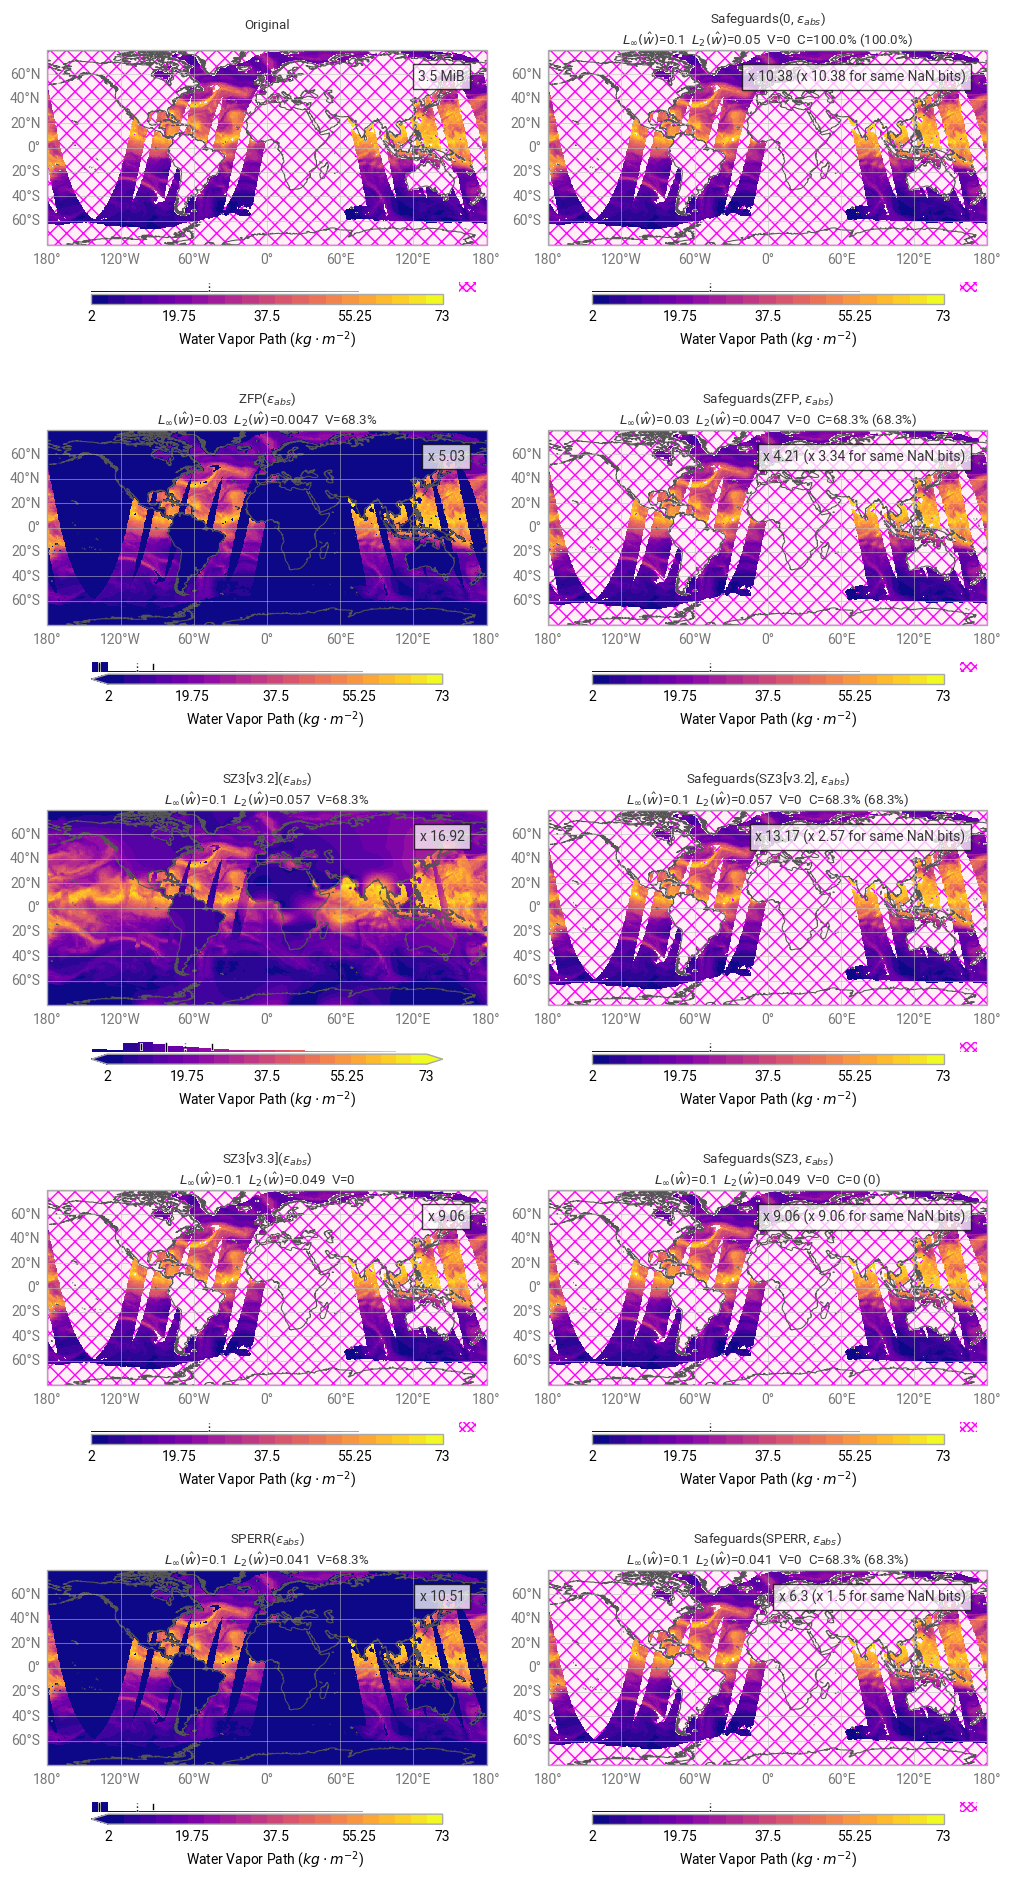

In [26]:
fig = earthkit.plots.Figure(
    size=(10, 19),
    rows=5,
    columns=2,
)

plot_wvpa(wvpa, 1.0, fig.add_map(0, 0), "Original", eb_abs=eb_abs)
plot_wvpa(
    wvpa_zfp,
    wvpa_zfp_cr,
    fig.add_map(1, 0),
    r"ZFP($\epsilon_{{abs}}$)",
    eb_abs=eb_abs,
    compressed=True,
)
plot_wvpa(
    wvpa_sz3_2,
    wvpa_sz3_2_cr,
    fig.add_map(2, 0),
    r"SZ3[v3.2]($\epsilon_{{abs}}$)",
    eb_abs=eb_abs,
    compressed=True,
)
plot_wvpa(
    wvpa_sz3_3,
    wvpa_sz3_3_cr,
    fig.add_map(3, 0),
    r"SZ3[v3.3]($\epsilon_{{abs}}$)",
    eb_abs=eb_abs,
    compressed=True,
)
plot_wvpa(
    wvpa_sperr,
    wvpa_sperr_cr,
    fig.add_map(4, 0),
    r"SPERR($\epsilon_{{abs}}$)",
    eb_abs=eb_abs,
    compressed=True,
)

plot_wvpa(
    wvpa_sg,
    wvpa_sg_cr,
    fig.add_map(0, 1),
    r"Safeguards(0, $\epsilon_{{abs}}$)",
    compressed=True,
    eb_abs=eb_abs,
    corr=wvpa_zero,
    nan_da=wvpa_sg_nan,
    nan_cr=wvpa_sg_nan_cr,
)
plot_wvpa(
    wvpa_zfp_sg,
    wvpa_zfp_sg_cr,
    fig.add_map(1, 1),
    r"Safeguards(ZFP, $\epsilon_{{abs}}$)",
    compressed=True,
    eb_abs=eb_abs,
    corr=wvpa_zfp,
    nan_da=wvpa_zfp_sg_nan,
    nan_cr=wvpa_zfp_sg_nan_cr,
)
plot_wvpa(
    wvpa_sz3_2_sg,
    wvpa_sz3_2_sg_cr,
    fig.add_map(2, 1),
    r"Safeguards(SZ3[v3.2], $\epsilon_{{abs}}$)",
    compressed=True,
    eb_abs=eb_abs,
    corr=wvpa_sz3_2,
    nan_da=wvpa_sz3_2_sg_nan,
    nan_cr=wvpa_sz3_2_sg_nan_cr,
)
plot_wvpa(
    wvpa_sz3_3_sg,
    wvpa_sz3_3_sg_cr,
    fig.add_map(3, 1),
    r"Safeguards(SZ3, $\epsilon_{{abs}}$)",
    compressed=True,
    eb_abs=eb_abs,
    corr=wvpa_sz3_3,
    nan_da=wvpa_sz3_3_sg_nan,
    nan_cr=wvpa_sz3_3_sg_nan_cr,
)
plot_wvpa(
    wvpa_sperr_sg,
    wvpa_sperr_sg_cr,
    fig.add_map(4, 1),
    r"Safeguards(SPERR, $\epsilon_{{abs}}$)",
    compressed=True,
    eb_abs=eb_abs,
    corr=wvpa_sperr,
    nan_da=wvpa_sperr_sg_nan,
    nan_cr=wvpa_sperr_sg_nan_cr,
)

fig.save("nan.pdf")